# Phase Transitions v2: Population Statistics and Token-Level Chaos

Dead tokens don't cool smoothly through phases. They *scatter* chaotically—hot one step, cold the next—until suddenly frozen forever. The "phases" are population statistics, not individual trajectories.

**Phases (cold to hot):**

| Phase | Criterion | Character |
|-------|-----------|----------|
| **Fimbulwinter** | L1 = 0, sustained | True heat death. Frozen solid. |
| **Stumbling** | L1 ∈ {0, 1} per step | Face-adjacent hops only. Lattice geometry dominates. |
| **Spherical** | |ΔW′|₂ ≤ √D | Neighboring cells including diagonals. Locally smooth. |
| **Superluminal** | √D < |ΔW′|₂ ≤ 1000 | Multi-cell teleportation. Discrete hops visible. |
| **Hypernova** | |ΔW′|₂ > 1000 | Explosive early chaos. Some tokens moving millions of cells. |

**Key insight:** The population transitions smoothly (erf-shaped boundary), but individuals are doing a random walk through phase space until they stumble into the absorbing state.

## Parameters

In [1]:
import torch
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Paths
INPUT_PATH = '../../tensors/Crucible-1/crucible_1_trajectory.safetensors'

# Dimensionality (for √D threshold)
D = 64
SQRT_D = np.sqrt(D)  # ~8.0

# Phase thresholds
THRESH_SPHERICAL = SQRT_D        # Below this: spherical (neighboring cells)
THRESH_SUPERLUMINAL = 1000.0     # Below this: superluminal; above: hypernova

# Plotting
DPI = 200
FIGSIZE = (14, 6)

print(f"√D = {SQRT_D:.2f}")

√D = 8.00


## Load Data

In [2]:
data = load_file(INPUT_PATH)
delta_W_prime = data['delta_W_prime']  # (steps, tokens, dims) float32

n_steps, n_tokens, n_dims = delta_W_prime.shape
print(f"Shape: {delta_W_prime.shape}")
print(f"Steps: {n_steps}, Dead tokens: {n_tokens}, Dims: {n_dims}")

Shape: torch.Size([5000, 3699, 64])
Steps: 5000, Dead tokens: 3699, Dims: 64


## Compute Displacement Norms

We need both L2 (for magnitude-based phases) and L1 (for stumbling detection).

In [3]:
# L2 norm: how far did the token move (Euclidean distance)
disp_l2 = torch.norm(delta_W_prime, dim=2)  # (steps, tokens)

# L1 norm: sum of absolute per-dimension displacements
# This counts "how many dimensions moved" roughly
disp_l1 = torch.abs(delta_W_prime).sum(dim=2)  # (steps, tokens)

# Handle infinities (from ULP divide-by-zero at exactly 0)
disp_l2 = torch.where(torch.isfinite(disp_l2), disp_l2, torch.zeros_like(disp_l2))
disp_l1 = torch.where(torch.isfinite(disp_l1), disp_l1, torch.zeros_like(disp_l1))

print(f"L2 range: [{disp_l2.min():.2f}, {disp_l2.max():.2f}]")
print(f"L1 range: [{disp_l1.min():.2f}, {disp_l1.max():.2f}]")

L2 range: [0.00, 9174821.00]
L1 range: [0.00, 11132284464698670435569384129847885824.00]


## Phase Classification

Classify each (token, step) into one of five phases.

In [4]:
# L2-based phases
is_hypernova = disp_l2 > THRESH_SUPERLUMINAL
is_superluminal = (disp_l2 > THRESH_SPHERICAL) & (disp_l2 <= THRESH_SUPERLUMINAL)
is_spherical = (disp_l2 > 0) & (disp_l2 <= THRESH_SPHERICAL)

# L1-based phases (stumbling and fimbulwinter)
is_fimbulwinter = disp_l1 == 0
is_stumbling = (disp_l1 > 0) & (disp_l1 <= 1.0)

# Verify: is_spherical should contain is_stumbling (stumbling is a subset of spherical in L2 terms)
# But we want stumbling to be its own category, so override:
# If L1 <= 1, it's stumbling regardless of L2
# If L1 > 1 and L2 <= √D, it's spherical
# If L1 > 1 and L2 > √D, it's superluminal or hypernova

# Recompute with proper hierarchy:
is_fimbulwinter = (disp_l1 == 0)
is_stumbling = (disp_l1 > 0) & (disp_l1 <= 1.0)
is_spherical = (disp_l1 > 1.0) & (disp_l2 <= THRESH_SPHERICAL)
is_superluminal = (disp_l1 > 1.0) & (disp_l2 > THRESH_SPHERICAL) & (disp_l2 <= THRESH_SUPERLUMINAL)
is_hypernova = (disp_l2 > THRESH_SUPERLUMINAL)

# Sanity check: should sum to 1
total = (is_fimbulwinter.float() + is_stumbling.float() + is_spherical.float() + 
         is_superluminal.float() + is_hypernova.float())
print(f"Sum check: min={total.min():.0f}, max={total.max():.0f} (should both be 1)")

# Count cells in each phase
total_cells = n_steps * n_tokens
print(f"\nPhase distribution (all {total_cells:,} cells):")
print(f"  Fimbulwinter: {is_fimbulwinter.sum().item():,} ({100*is_fimbulwinter.sum().item()/total_cells:.1f}%)")
print(f"  Stumbling:    {is_stumbling.sum().item():,} ({100*is_stumbling.sum().item()/total_cells:.1f}%)")
print(f"  Spherical:    {is_spherical.sum().item():,} ({100*is_spherical.sum().item()/total_cells:.1f}%)")
print(f"  Superluminal: {is_superluminal.sum().item():,} ({100*is_superluminal.sum().item()/total_cells:.1f}%)")
print(f"  Hypernova:    {is_hypernova.sum().item():,} ({100*is_hypernova.sum().item()/total_cells:.1f}%)")

Sum check: min=1, max=1 (should both be 1)

Phase distribution (all 18,495,000 cells):
  Fimbulwinter: 16,003,934 (86.5%)
  Stumbling:    900,256 (4.9%)
  Spherical:    1,104,544 (6.0%)
  Superluminal: 440,696 (2.4%)
  Hypernova:    45,570 (0.2%)


## Population Statistics: Fraction in Each Phase Over Time

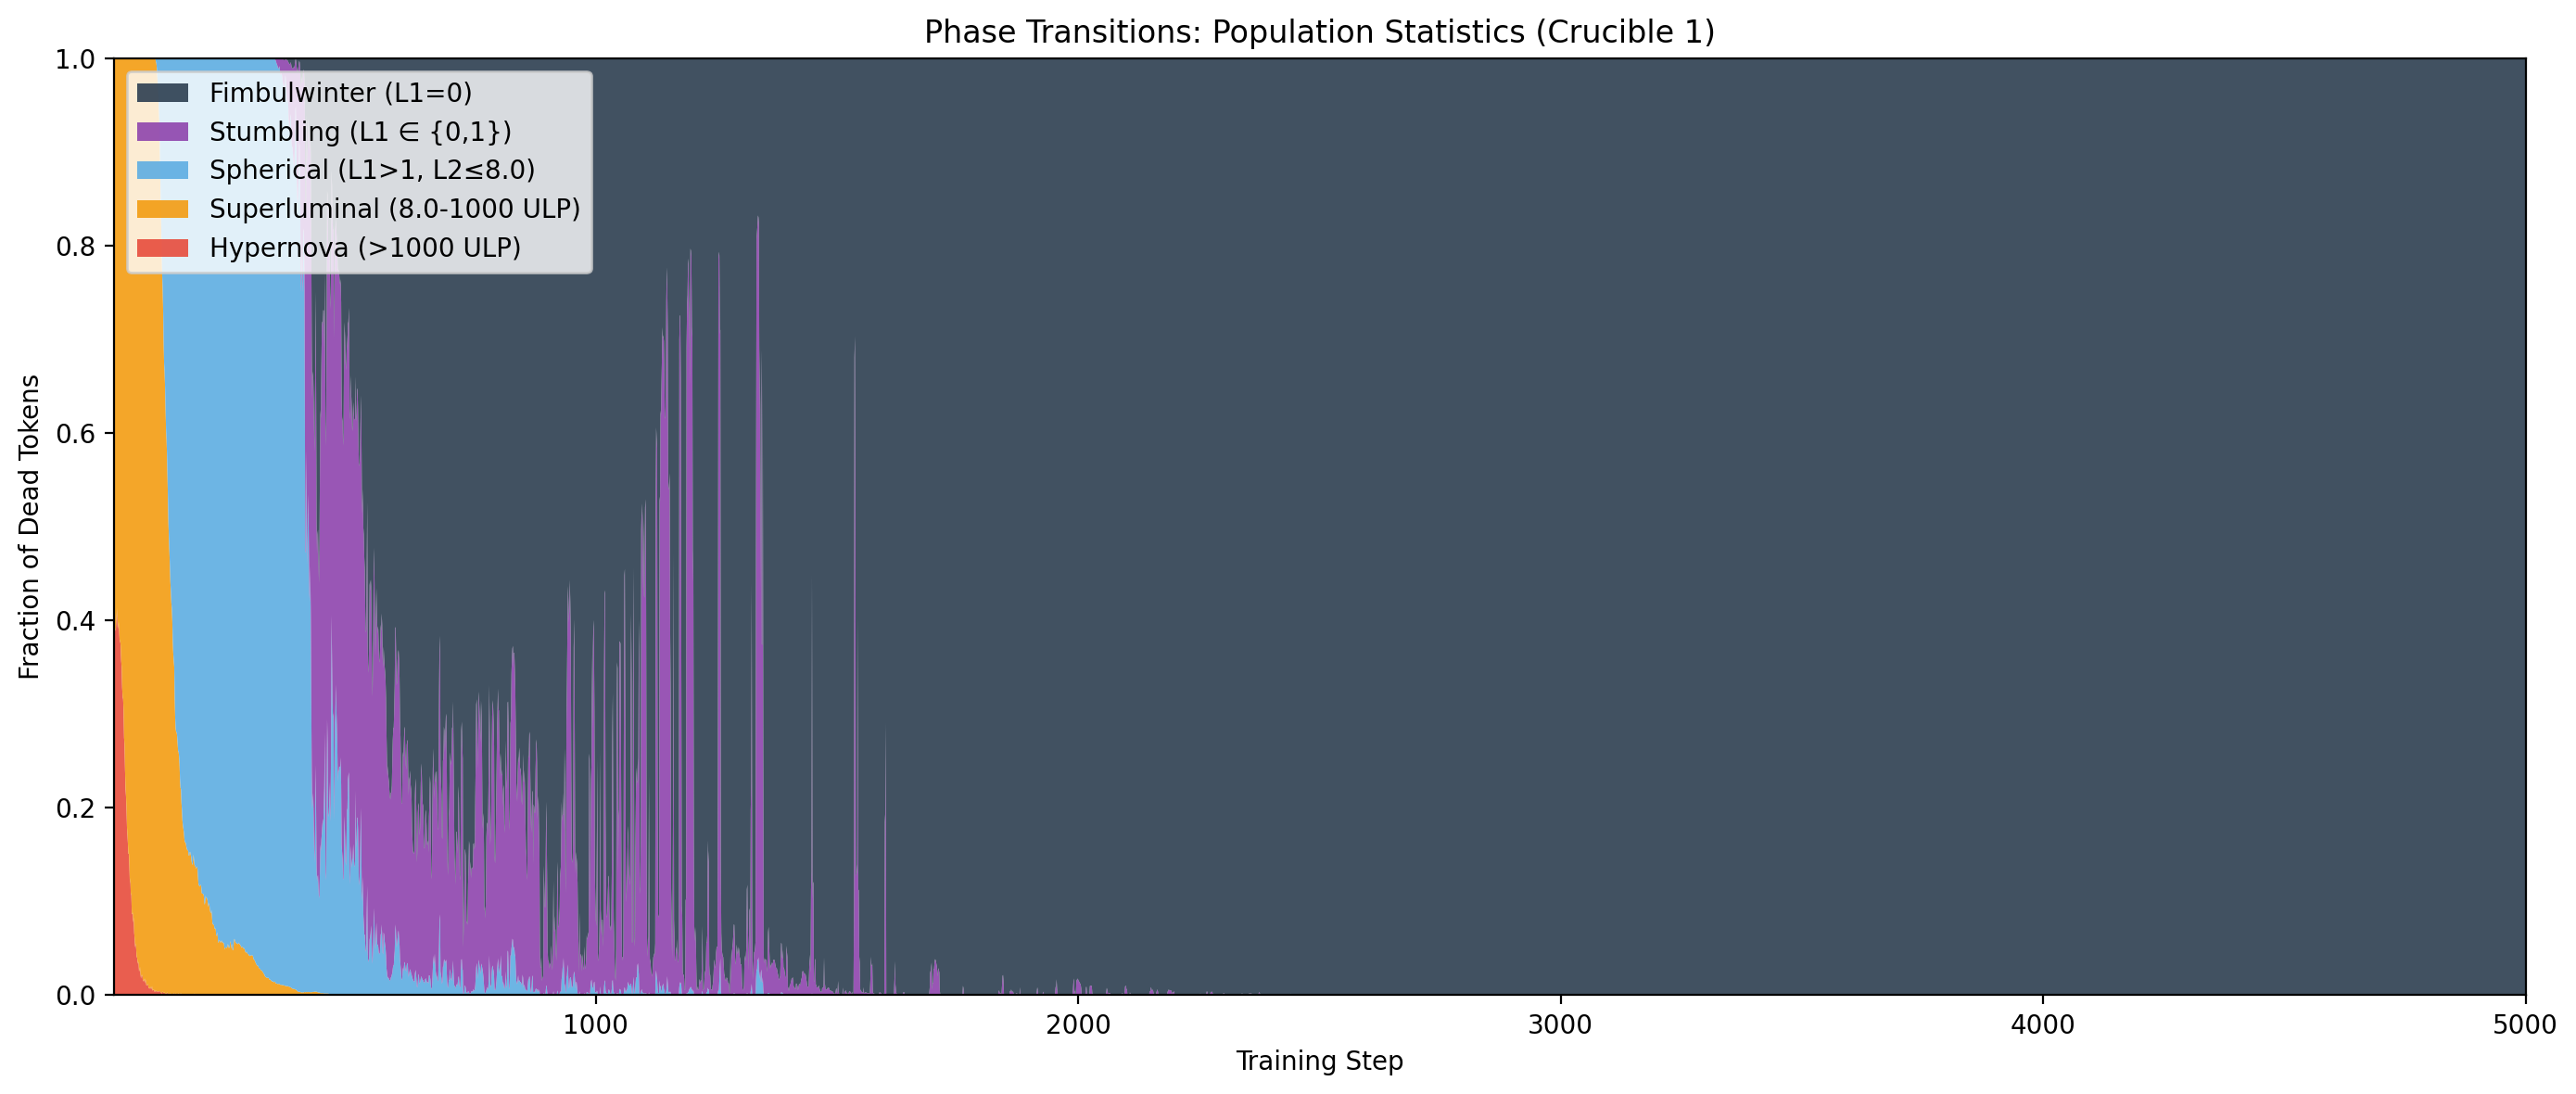

In [5]:
# Compute fractions at each timestep
frac_fimbulwinter = is_fimbulwinter.float().mean(dim=1).numpy()
frac_stumbling = is_stumbling.float().mean(dim=1).numpy()
frac_spherical = is_spherical.float().mean(dim=1).numpy()
frac_superluminal = is_superluminal.float().mean(dim=1).numpy()
frac_hypernova = is_hypernova.float().mean(dim=1).numpy()

steps = np.arange(1, n_steps + 1)

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Stack from bottom (hot) to top (cold)
ax.stackplot(
    steps,
    frac_hypernova,
    frac_superluminal,
    frac_spherical,
    frac_stumbling,
    frac_fimbulwinter,
    labels=[
        f'Hypernova (>{THRESH_SUPERLUMINAL:.0f} ULP)',
        f'Superluminal ({SQRT_D:.1f}-{THRESH_SUPERLUMINAL:.0f} ULP)',
        f'Spherical (L1>1, L2≤{SQRT_D:.1f})',
        'Stumbling (L1 ∈ {0,1})',
        'Fimbulwinter (L1=0)',
    ],
    colors=['#e74c3c', '#f39c12', '#5dade2', '#8e44ad', '#2c3e50'],
    alpha=0.9
)

ax.set_xlabel('Training Step')
ax.set_ylabel('Fraction of Dead Tokens')
ax.set_title('Phase Transitions: Population Statistics (Crucible 1)')
ax.set_xlim(1, n_steps)
ax.set_ylim(0, 1)

# Legend in reverse order to match visual stacking
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left')

plt.tight_layout()
plt.show()

## Transition Statistics

In [6]:
print("=" * 60)
print("PHASE TRANSITION STATISTICS")
print("=" * 60)

# When does each phase drop below thresholds?
for name, frac in [('Hypernova', frac_hypernova), ('Superluminal', frac_superluminal)]:
    for thresh in [0.5, 0.1, 0.01, 0.001]:
        idx = np.where(frac <= thresh)[0]
        if len(idx) > 0:
            print(f"{name} drops below {thresh:.1%} at step {idx[0] + 1}")
            break
    print()

# When does Fimbulwinter reach milestones?
for thresh in [0.5, 0.9, 0.99, 1.0]:
    idx = np.where(frac_fimbulwinter >= thresh)[0]
    if len(idx) > 0:
        print(f"Fimbulwinter reaches {thresh:.0%} at step {idx[0] + 1}")
    else:
        print(f"Fimbulwinter never reaches {thresh:.0%}")

print()
print(f"Final state (step {n_steps}):")
print(f"  Fimbulwinter:  {frac_fimbulwinter[-1]:.1%}")
print(f"  Stumbling:     {frac_stumbling[-1]:.1%}")
print(f"  Spherical:     {frac_spherical[-1]:.1%}")
print(f"  Superluminal:  {frac_superluminal[-1]:.1%}")
print(f"  Hypernova:     {frac_hypernova[-1]:.1%}")

PHASE TRANSITION STATISTICS
Hypernova drops below 50.0% at step 1

Superluminal drops below 50.0% at step 115

Fimbulwinter reaches 50% at step 422
Fimbulwinter reaches 90% at step 725
Fimbulwinter reaches 99% at step 1184
Fimbulwinter reaches 100% at step 1586

Final state (step 5000):
  Fimbulwinter:  100.0%
  Stumbling:     0.0%
  Spherical:     0.0%
  Superluminal:  0.0%
  Hypernova:     0.0%


## Token-Level Chaos: Do Tokens Ever "Reheat"?

If tokens cooled monotonically, we'd expect phase transitions to be one-way. But if tokens can jump back from cold to hot, that tells us something about the stochastic dynamics.

In [7]:
# Encode phase as integers: 0=fimbulwinter, 1=stumbling, 2=spherical, 3=superluminal, 4=hypernova
phase_code = torch.zeros_like(disp_l2, dtype=torch.int8)
phase_code[is_stumbling] = 1
phase_code[is_spherical] = 2
phase_code[is_superluminal] = 3
phase_code[is_hypernova] = 4

# Compute phase transitions: phase[t+1] - phase[t]
# Positive = heating (moving to hotter phase)
# Negative = cooling (moving to colder phase)
phase_diff = phase_code[1:] - phase_code[:-1]  # (steps-1, tokens)

# Count reheating events (phase_diff > 0)
n_reheat = (phase_diff > 0).sum().item()
n_cool = (phase_diff < 0).sum().item()
n_same = (phase_diff == 0).sum().item()

total_transitions = (n_steps - 1) * n_tokens
print(f"Transitions across all tokens and steps:")
print(f"  Reheating (cold→hot): {n_reheat:,} ({100*n_reheat/total_transitions:.2f}%)")
print(f"  Cooling (hot→cold):   {n_cool:,} ({100*n_cool/total_transitions:.2f}%)")
print(f"  Same phase:           {n_same:,} ({100*n_same/total_transitions:.2f}%)")
print(f"\nReheat/Cool ratio: {n_reheat/max(n_cool,1):.3f}")

Transitions across all tokens and steps:
  Reheating (cold→hot): 174,006 (0.94%)
  Cooling (hot→cold):   186,466 (1.01%)
  Same phase:           18,130,829 (98.05%)

Reheat/Cool ratio: 0.933


In [8]:
# Where do reheating events happen? (which phases, which timesteps)
reheat_mask = phase_diff > 0
reheat_steps, reheat_tokens = torch.where(reheat_mask)

# What phase were they in before reheating?
before_phase = phase_code[:-1][reheat_mask]

phase_names = ['Fimbulwinter', 'Stumbling', 'Spherical', 'Superluminal', 'Hypernova']
print("Reheating events by source phase:")
for i, name in enumerate(phase_names[:-1]):  # Can't reheat from hypernova
    count = (before_phase == i).sum().item()
    print(f"  {name} → hotter: {count:,}")

print(f"\nReheating events by timestep (first 500 steps):")
for start in [0, 100, 200, 300, 400]:
    end = start + 100
    count = ((reheat_steps >= start) & (reheat_steps < end)).sum().item()
    print(f"  Steps {start:3d}-{end:3d}: {count:,}")

Reheating events by source phase:
  Fimbulwinter → hotter: 118,870
  Stumbling → hotter: 22,309
  Spherical → hotter: 2,287
  Superluminal → hotter: 30,540

Reheating events by timestep (first 500 steps):
  Steps   0-100: 30,012
  Steps 100-200: 1,971
  Steps 200-300: 718
  Steps 300-400: 3,752
  Steps 400-500: 16,728


## Terminal Trajectories: Last N Steps Before Freeze

What does a token's final approach to Fimbulwinter look like?

In [9]:
# Find the freeze time for each token (first step where it enters permanent fimbulwinter)
# A token is "frozen" if it's in fimbulwinter and stays there forever

# Start from the end and work backwards to find last motion
last_motion = torch.zeros(n_tokens, dtype=torch.long)
for token_idx in range(n_tokens):
    token_l1 = disp_l1[:, token_idx]
    motion_steps = torch.where(token_l1 > 0)[0]
    if len(motion_steps) > 0:
        last_motion[token_idx] = motion_steps[-1].item()
    else:
        last_motion[token_idx] = -1  # Never moved

print(f"Last motion step range: [{last_motion.min().item()}, {last_motion.max().item()}]")
print(f"Tokens that never moved: {(last_motion == -1).sum().item()}")

Last motion step range: [559, 2508]
Tokens that never moved: 0


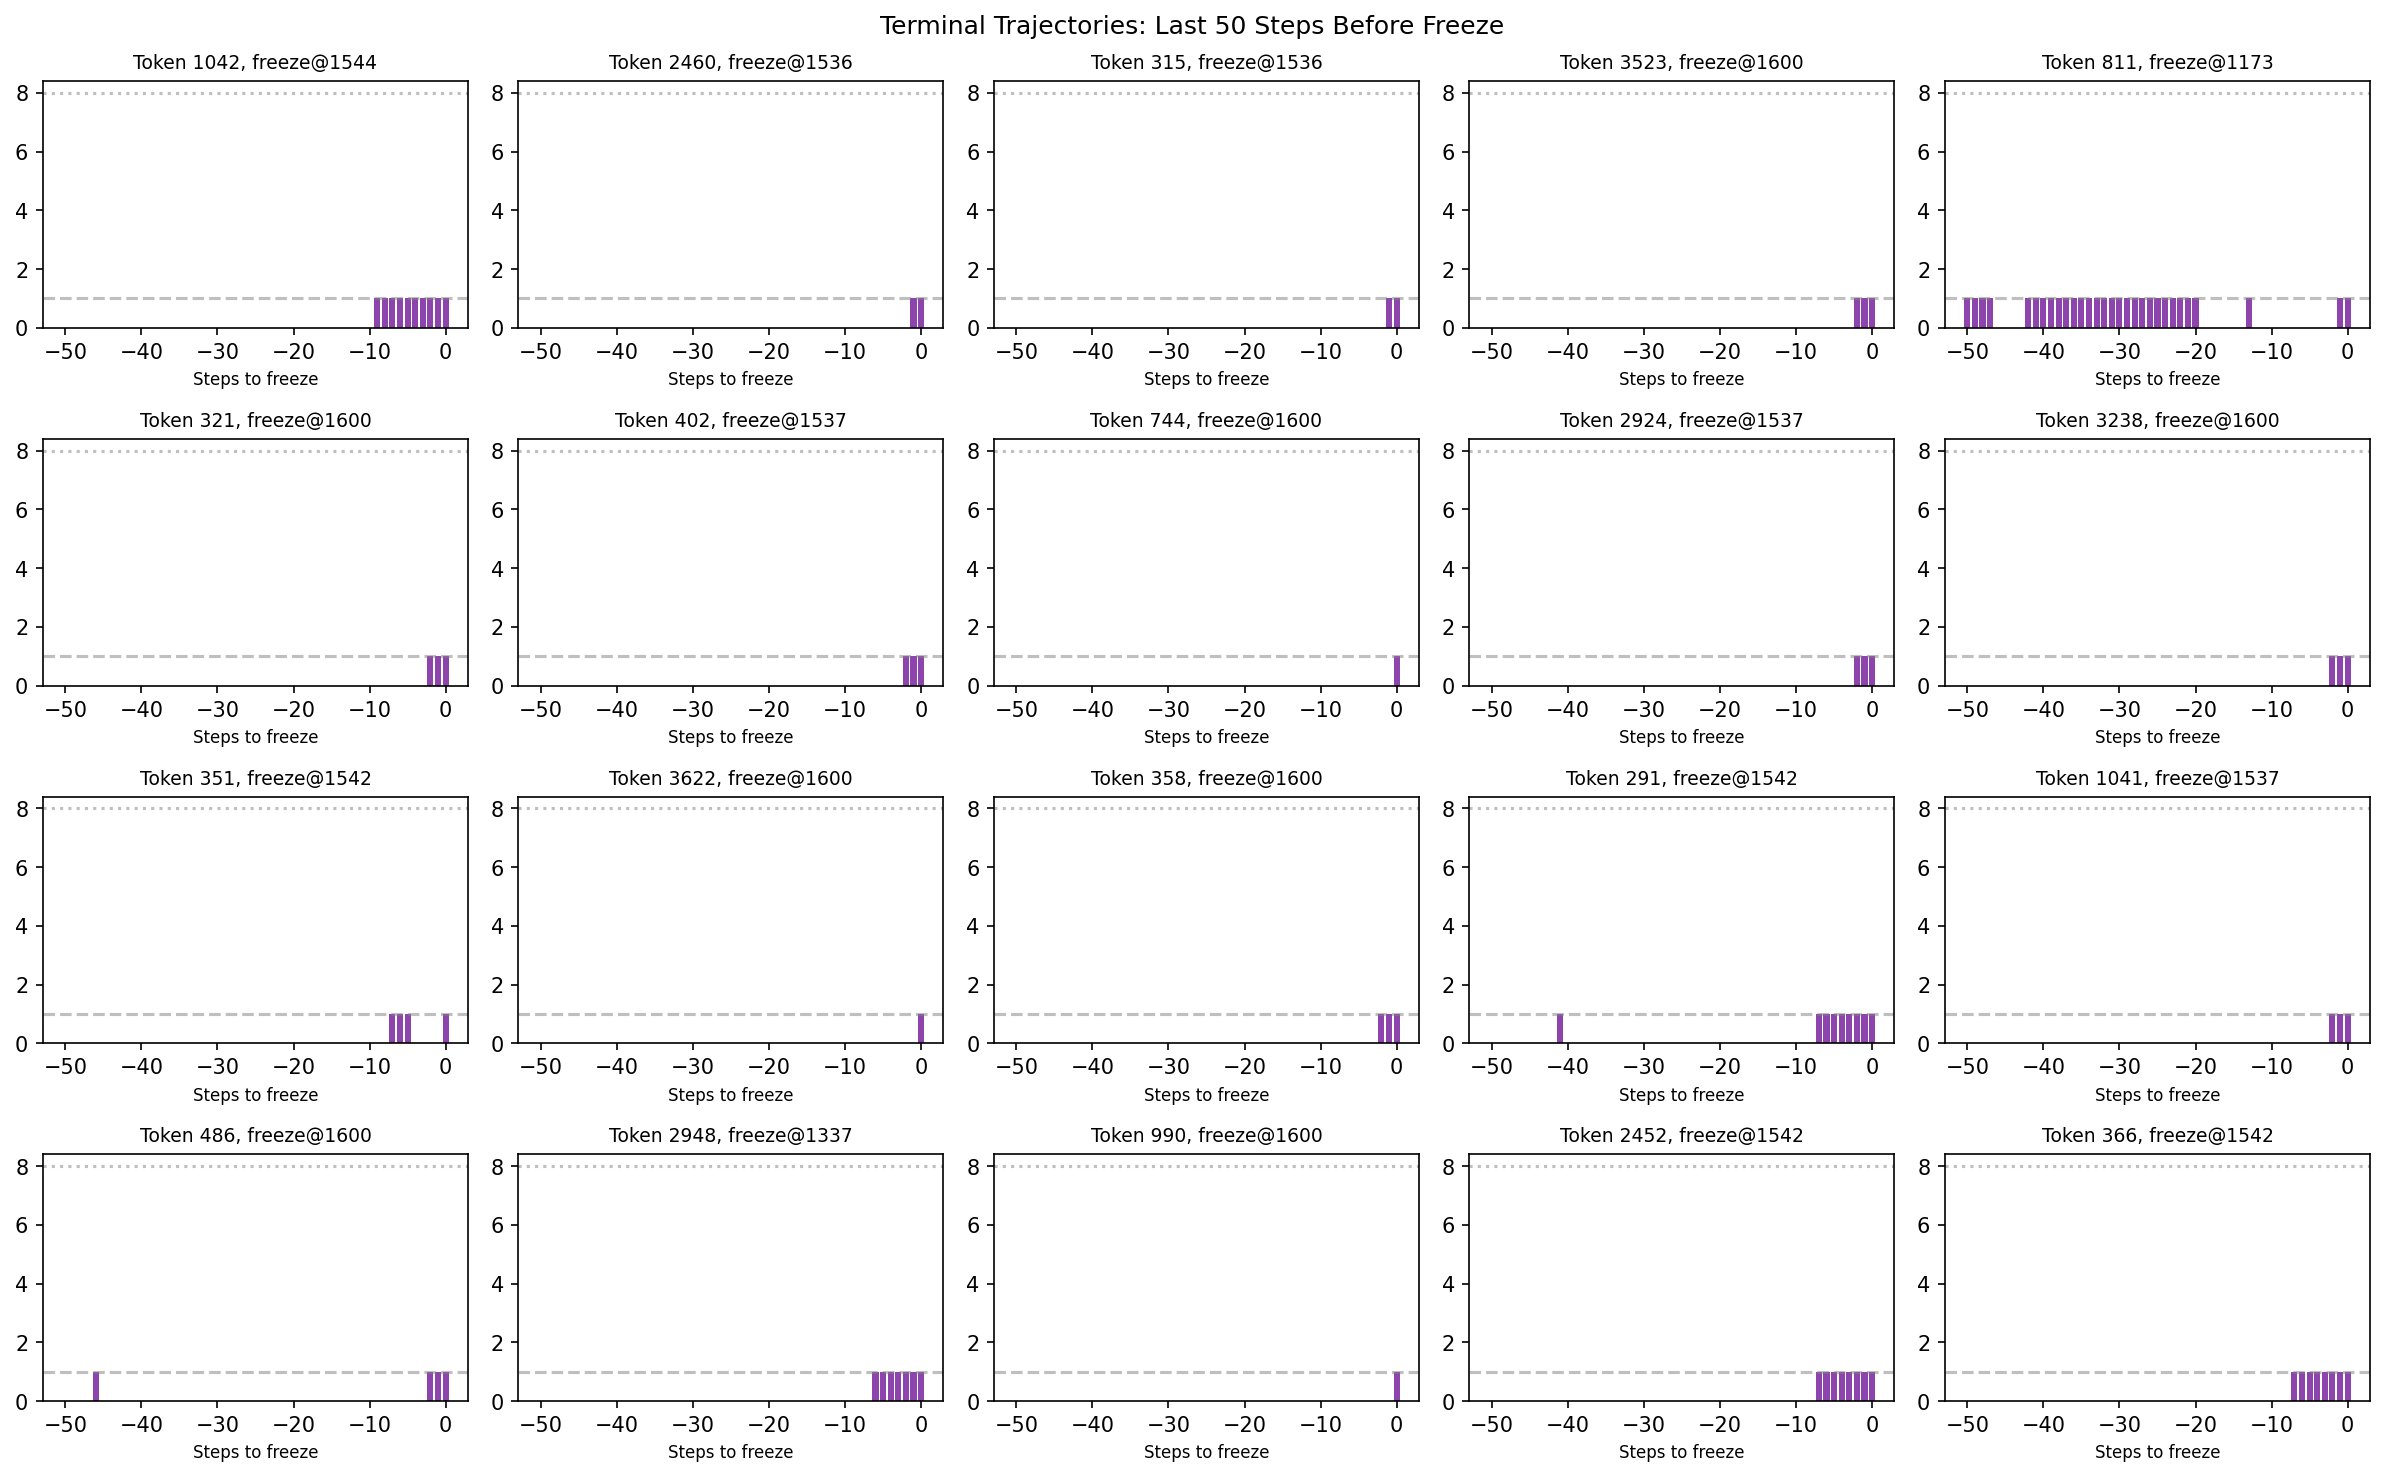

In [10]:
# Look at the last 50 steps before freeze for a sample of tokens
LOOKBACK = 50
N_SAMPLE = 20

# Sample tokens with different freeze times
np.random.seed(42)
valid_tokens = torch.where(last_motion >= LOOKBACK)[0]
sample_indices = valid_tokens[np.random.choice(len(valid_tokens), min(N_SAMPLE, len(valid_tokens)), replace=False)]

fig, axes = plt.subplots(4, 5, figsize=(16, 10), dpi=150)
axes = axes.flatten()

for ax_idx, token_idx in enumerate(sample_indices):
    freeze_step = last_motion[token_idx].item()
    start_step = max(0, freeze_step - LOOKBACK)
    
    # Get L1 displacement for this token's final approach
    token_l1 = disp_l1[start_step:freeze_step+1, token_idx].numpy()
    token_phase = phase_code[start_step:freeze_step+1, token_idx].numpy()
    
    steps_rel = np.arange(-(freeze_step - start_step), 1)  # Relative to freeze
    
    ax = axes[ax_idx]
    colors = ['#2c3e50', '#8e44ad', '#5dade2', '#f39c12', '#e74c3c']
    for i in range(len(steps_rel)):
        ax.bar(steps_rel[i], token_l1[i], color=colors[token_phase[i]], width=0.8)
    
    ax.set_title(f'Token {token_idx.item()}, freeze@{freeze_step}', fontsize=9)
    ax.set_xlabel('Steps to freeze', fontsize=8)
    ax.axhline(1, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(SQRT_D, color='gray', linestyle=':', alpha=0.5)

plt.suptitle('Terminal Trajectories: Last 50 Steps Before Freeze', fontsize=12)
plt.tight_layout()
plt.show()

## Full Heatmap: All Tokens, Sorted by Freeze Time

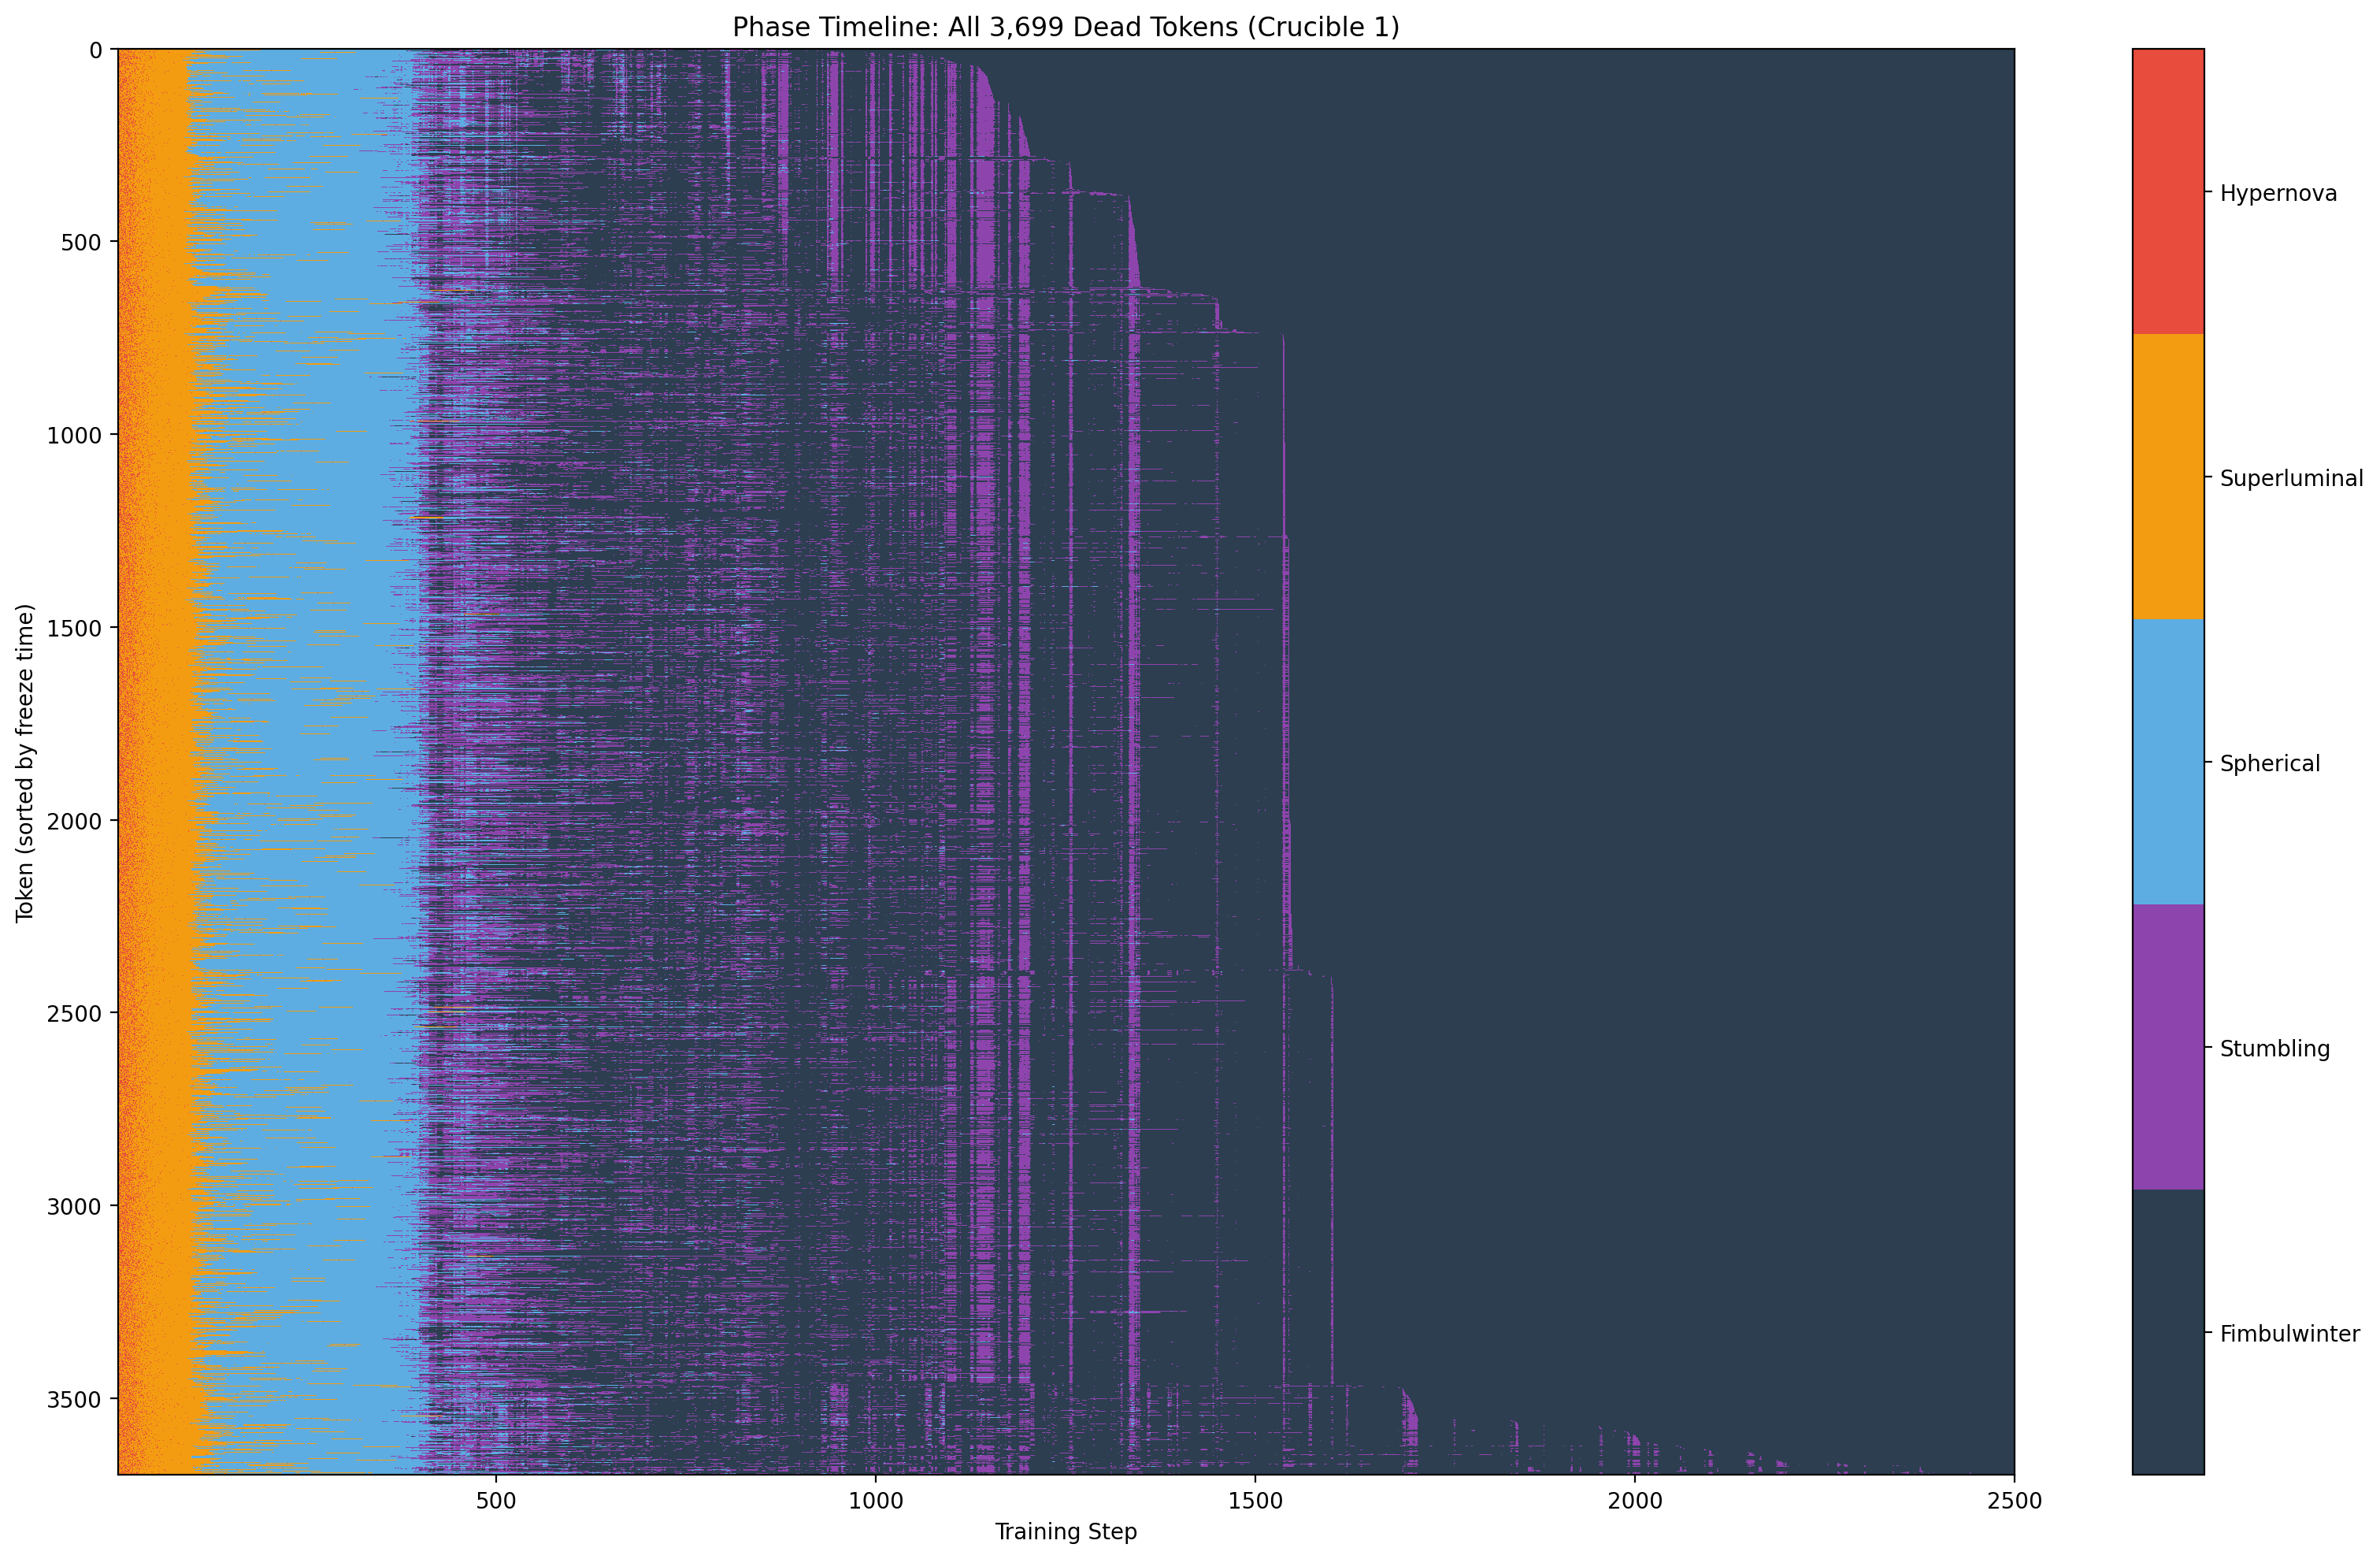

In [13]:
fig, ax = plt.subplots(figsize=(16, 10), dpi=200)

# Sort tokens by freeze time
freeze_order = torch.argsort(last_motion).numpy()
phase_sorted = phase_code[:, freeze_order].numpy().T  # (tokens, steps)

# Custom colormap: fimbulwinter(0), stumbling(1), spherical(2), superluminal(3), hypernova(4)
cmap = ListedColormap(['#2c3e50', '#8e44ad', '#5dade2', '#f39c12', '#e74c3c'])

im = ax.imshow(phase_sorted, aspect='auto', cmap=cmap, vmin=0, vmax=4,
               extent=[1, n_steps, n_tokens, 0], interpolation='nearest')

ax.set_xlabel('Training Step')
ax.set_ylabel('Token (sorted by freeze time)')
ax.set_title(f'Phase Timeline: All {n_tokens:,} Dead Tokens (Crucible 1)')

ax.set_xlim(1, 2500)

# Colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0.4, 1.2, 2.0, 2.8, 3.6])
cbar.ax.set_yticklabels(['Fimbulwinter', 'Stumbling', 'Spherical', 'Superluminal', 'Hypernova'])

plt.tight_layout()
plt.show()

## Zoomed Heatmap: First 500 Steps (Hot Phase Detail)

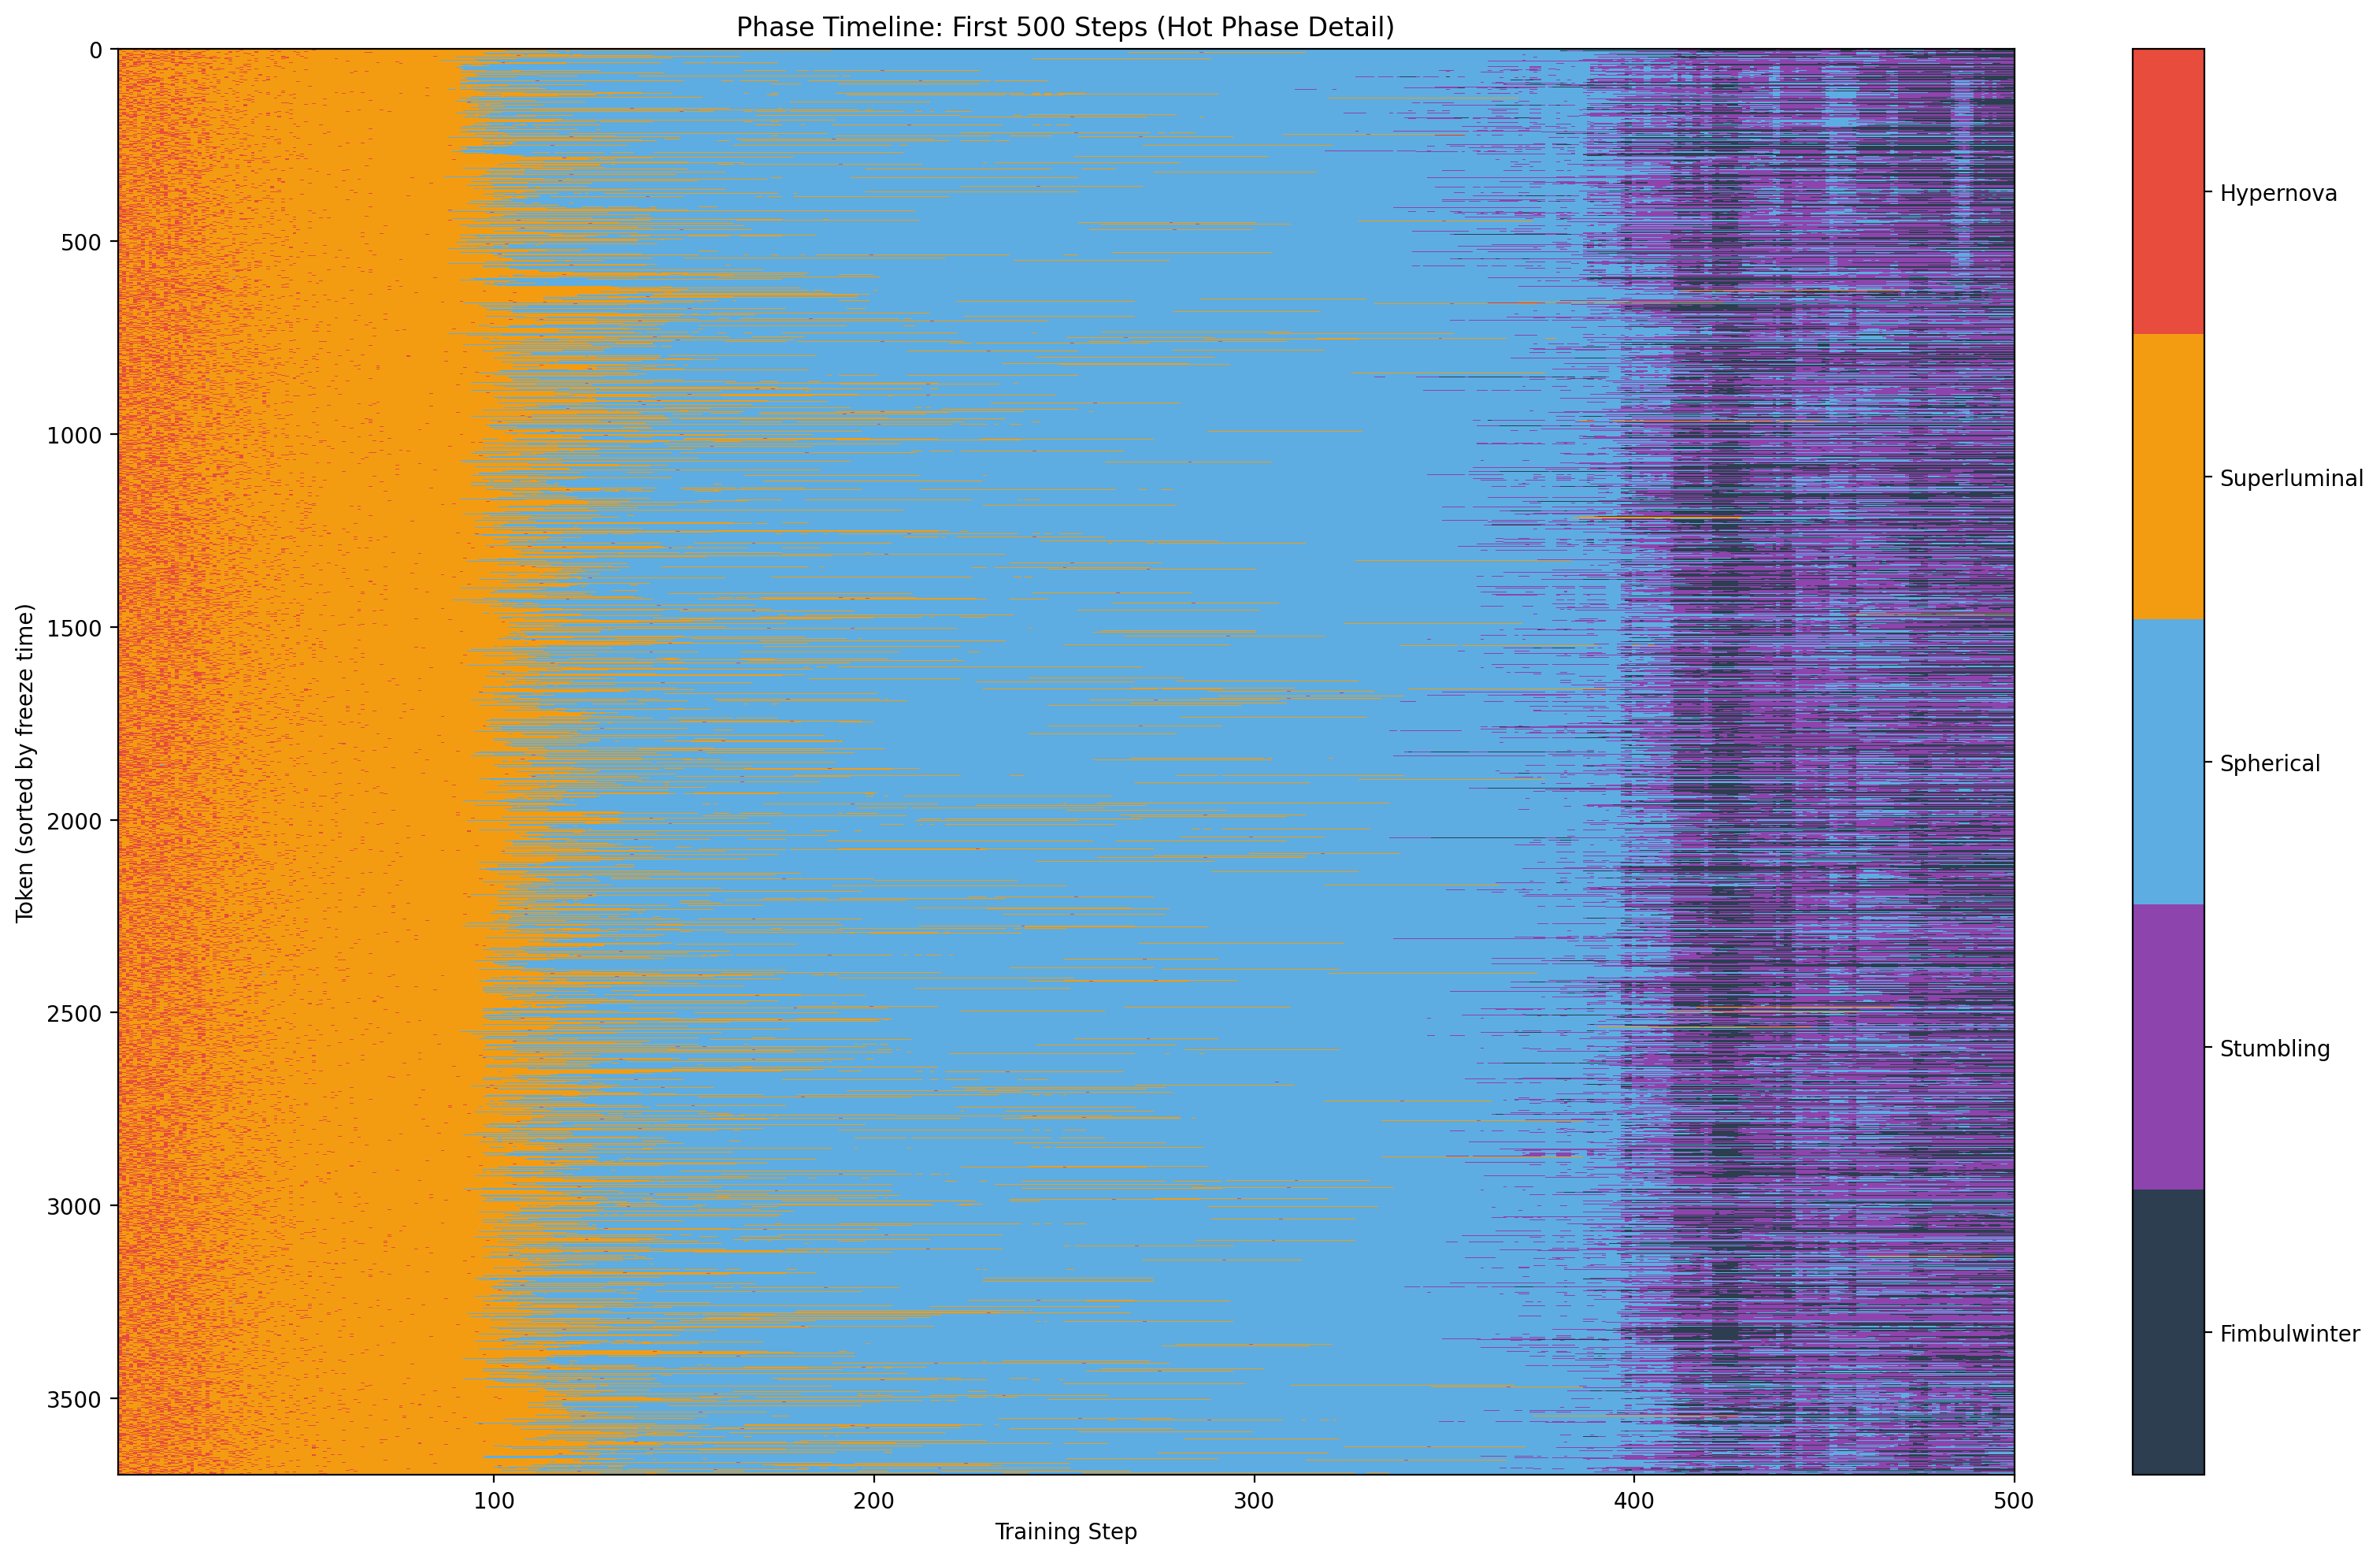

In [17]:
fig, ax = plt.subplots(figsize=(16, 10), dpi=200)

im = ax.imshow(phase_sorted[:, :500], aspect='auto', cmap=cmap, vmin=0, vmax=4,
               extent=[1, 500, n_tokens, 0], interpolation='nearest')

ax.set_xlabel('Training Step')
ax.set_ylabel('Token (sorted by freeze time)')
ax.set_title(f'Phase Timeline: First 500 Steps (Hot Phase Detail)')

cbar = plt.colorbar(im, ax=ax, ticks=[0.4, 1.2, 2.0, 2.8, 3.6])
cbar.ax.set_yticklabels(['Fimbulwinter', 'Stumbling', 'Spherical', 'Superluminal', 'Hypernova'])

plt.tight_layout()
plt.show()